In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import glob
from matplotlib.ticker import FixedLocator, FixedFormatter

from libraries import Libraries

In [ ]:
import pysindy as ps

In [2]:
frac = 1 # what fraction of data to work at. 1 for 100 data, .8 for 80, .6 for 60, .4 for 40, .2 for 20, .1 for 10 data
deg = 4
deg_trigo = 4
np.random.seed(142)

In [3]:
path = r'data/ellipsoid_inclined_data' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    frame = pd.read_csv(filename, index_col=None, header=0)
    li.append(frame)

df = pd.concat(li, axis=0, ignore_index=True)
df = pd.DataFrame(df, columns= ['Re', 'phi', 'theta', 'Exp C_d'])

shuffled_df = df.sample(frac=frac)

data = shuffled_df.to_numpy()
Re = data[:,0]
phi = data[:,1]
theta = data[:,2]
Cd = data[:,3]
inp = data[:,0:3]


In [4]:

inp_train, inp_test, Cd_train, Cd_test = train_test_split(inp, Cd, test_size=0.2, shuffle=True)
Re_train = inp_train[:,0]
phi_train = inp_train[:,1]
theta_train = inp_train[:,2]
Re_test = inp_test[:,0]
phi_test = inp_test[:,1]
theta_test = inp_test[:,2]


In [8]:
mode_list = ['phim1', 'basic', 'basicphim1', 'trig']
alphas = np.linspace(1e-2, 1e5, 10) 
results = {mode: {} for mode in mode_list}
verbose = True

for i in range(len(mode_list)):
    mode = mode_list[i]
    L = Libraries(mode, deg, deg_trigo)
    library_train, library_names = L.library(Re_train, phi_train, theta_train)
    library_test, library_names = L.library(Re_test, phi_test, theta_test)

    reg = linear_model.LassoCV(fit_intercept=False, alphas=alphas, positive=True, tol=1e-3, max_iter=1000000)
    reg.fit(library_train, Cd_train)

    Cd_pred = reg.predict(library_test)
    train_score = reg.score(library_train, Cd_train)
    test_score = reg.score(library_test, Cd_test)

    rmse_train = np.sqrt(mean_squared_error(Cd_train, reg.predict(library_train)))
    rmse_test = np.sqrt(mean_squared_error(Cd_test, reg.predict(library_test)))

    coefs = reg.coef_
    learned_dict = list(zip(library_names, coefs))

    learned_coefs = []
    learned_libs = []
    for i in range(len(learned_dict)):
        if np.abs(learned_dict[i][1]) > 0:
            learned_coefs.append(learned_dict[i][1])
            learned_libs.append(learned_dict[i][0])

    results[mode]['losses'] = [rmse_train, rmse_test, train_score, test_score]
    results[mode]['learned_coefs'] = learned_coefs
    results[mode]['learned_libs'] = learned_libs
    results[mode]['library_names'] = library_names
    results[mode]['reg'] = reg

    
    if verbose:
        print('\nMODE: ', mode)

        print('alpha = ', reg.alpha_)
        print("train score: ",train_score)
        print("test score: ",test_score)

        print("RMSE train: ",rmse_train)
        print("RMSE test: ",rmse_test)
        print("----")

        for i in range(len(learned_dict)):
            if np.abs(learned_dict[i][1]) > 0:
                print(f'{learned_dict[i][1]:.4f} \t {learned_dict[i][0]}')

        print("=============")


MODE:  phim1
alpha =  0.01
train score:  0.9976343816497764
test score:  0.9971322934947583
RMSE train:  196.10642684986144
RMSE test:  243.59160312550932
----
12.7150 	 Re^-1phi^-1
12.3298 	 Re^-1phi^0
22.3866 	 Re^0phi^0
0.0174 	 Re^-1 (phi-1)^1 theta^0
0.5029 	 Re^-1 (phi-1)^1 theta^2

MODE:  basic
alpha =  0.01
train score:  0.9989888262615797
test score:  0.9993182452325945
RMSE train:  128.2130930771108
RMSE test:  118.77062850055476
----
0.0002 	 Re^-2 phi^0 theta^0
16.0329 	 Re^-1 phi^-1 theta^0
0.0077 	 Re^-1 phi^-1 theta^4
9.0253 	 Re^-1 phi^0 theta^0
0.5143 	 Re^-1 phi^0 theta^1
0.3499 	 Re^-1 phi^0 theta^2
0.4163 	 Re^-1 phi^1 theta^0
0.4359 	 Re^-1 phi^1 theta^1
19.1644 	 Re^0 phi^0 theta^0
1.0042 	 Re^0 phi^0 theta^2

MODE:  basicphim1
alpha =  0.01
train score:  0.9989888262615797
test score:  0.9993182452325945
RMSE train:  128.2130930771108
RMSE test:  118.77062850055476
----
0.0002 	 Re^-2 (phi-1)^0 theta^0
16.0329 	 Re^-1 (phi-1)^-1 theta^0
0.0077 	 Re^-1 (phi-1)^-1

In [10]:
# Plot results and compare with data
# Start with Re=0.1 and phi = 6

Re0 = Re_list[2] 
phi0 = phi_list[1] 

print('Re = ', Re0, '; phi = ', phi0)

datafilt = shuffled_df[(shuffled_df['Re'] == Re0) & (shuffled_df['phi'] == phi0)]
theta_list = np.array(datafilt['theta'])
Cd_list = np.array(datafilt['Exp C_d'])

idxsort = np.argsort(theta_list)
theta_sorted = theta_list[idxsort]
Cd_sorted = Cd_list[idxsort]


Re =  0.0022 ; phi =  3.0


/Users/josephbakarji/Documents/academic/research/buckipi-cylinder-flow/PNAS/libraries.py:23: RuntimeWarning: invalid value encountered in reciprocal
  lib1[:,counter] = Re**i * phi**j
/Users/josephbakarji/Documents/academic/research/buckipi-cylinder-flow/PNAS/libraries.py:31: RuntimeWarning: invalid value encountered in reciprocal
  lib2[:,counter] = Re**k * (phi-1)**i * theta**(2*j)
/Users/josephbakarji/Documents/academic/research/buckipi-cylinder-flow/PNAS/libraries.py:48: RuntimeWarning: invalid value encountered in reciprocal
  lib[:,counter] = Re**i * phi**j * theta**k
/Users/josephbakarji/Documents/academic/research/buckipi-cylinder-flow/PNAS/libraries.py:61: RuntimeWarning: invalid value encountered in reciprocal
  lib[:,counter] = Re**i * phi**j * theta**k
/Users/josephbakarji/Documents/academic/research/buckipi-cylinder-flow/PNAS/libraries.py:74: RuntimeWarning: invalid value encountered in reciprocal
  lib[:,counter] = Re**i * phi**j * np.cos(k*theta)


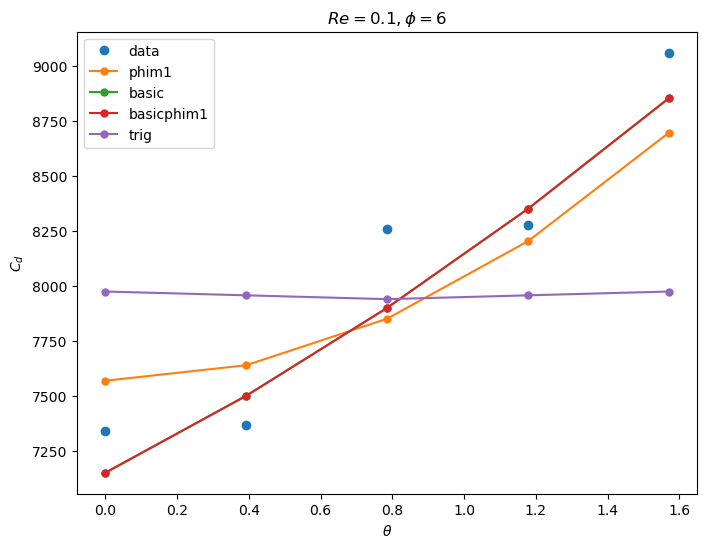

In [11]:
# Plot

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(theta_sorted, Cd_sorted, 'o', label='data')

for mode in mode_list:
    L = Libraries(mode, deg, deg_trigo)
    lib, lib_names = L.library(np.array(datafilt['Re']), np.array(datafilt['phi'], dtype=float), theta_sorted)
    Cd_pred = results[mode]['reg'].predict(lib)
    ax.plot(theta_sorted, Cd_pred, '.-', ms=10, label=mode)


ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$C_d$')
ax.set_title(r'$Re = 0.1, \phi = 6$')
ax.legend()
plt.show()


In [ ]:
# List of Re and phi values in data

Re_list = np.unique(Re)
phi_list = np.unique(phi)
theta = {}

XRe, Yphi = np.meshgrid(Re_list, phi_list)

Z = np.zeros((len(theta_list), len(Re_list)))
for i in range(len(Re_list)):
    for j in range(len(phi_list)):
        thetas[(i, j)] = shuffled_df['theta'][shuffled_df['Re'] == Re_list[i]][shuffled_df['phi'] == phi_list[j]]



array([0.00462963, 0.00462963, 0.00462963, 0.00462963, 0.00462963])

/Users/josephbakarji/Documents/academic/research/buckipi-cylinder-flow/PNAS/libraries.py:23: RuntimeWarning: invalid value encountered in reciprocal
  lib1[:,counter] = Re**i * phi**j
/Users/josephbakarji/Documents/academic/research/buckipi-cylinder-flow/PNAS/libraries.py:31: RuntimeWarning: invalid value encountered in reciprocal
  lib2[:,counter] = Re**k * (phi-1)**i * theta**(2*j)
/Users/josephbakarji/Documents/academic/research/buckipi-cylinder-flow/PNAS/libraries.py:48: RuntimeWarning: invalid value encountered in reciprocal
  lib[:,counter] = Re**i * phi**j * theta**k
/Users/josephbakarji/Documents/academic/research/buckipi-cylinder-flow/PNAS/libraries.py:61: RuntimeWarning: invalid value encountered in reciprocal
  lib[:,counter] = Re**i * phi**j * theta**k
/Users/josephbakarji/Documents/academic/research/buckipi-cylinder-flow/PNAS/libraries.py:23: RuntimeWarning: invalid value encountered in reciprocal
  lib1[:,counter] = Re**i * phi**j
/Users/josephbakarji/Documents/academic/r

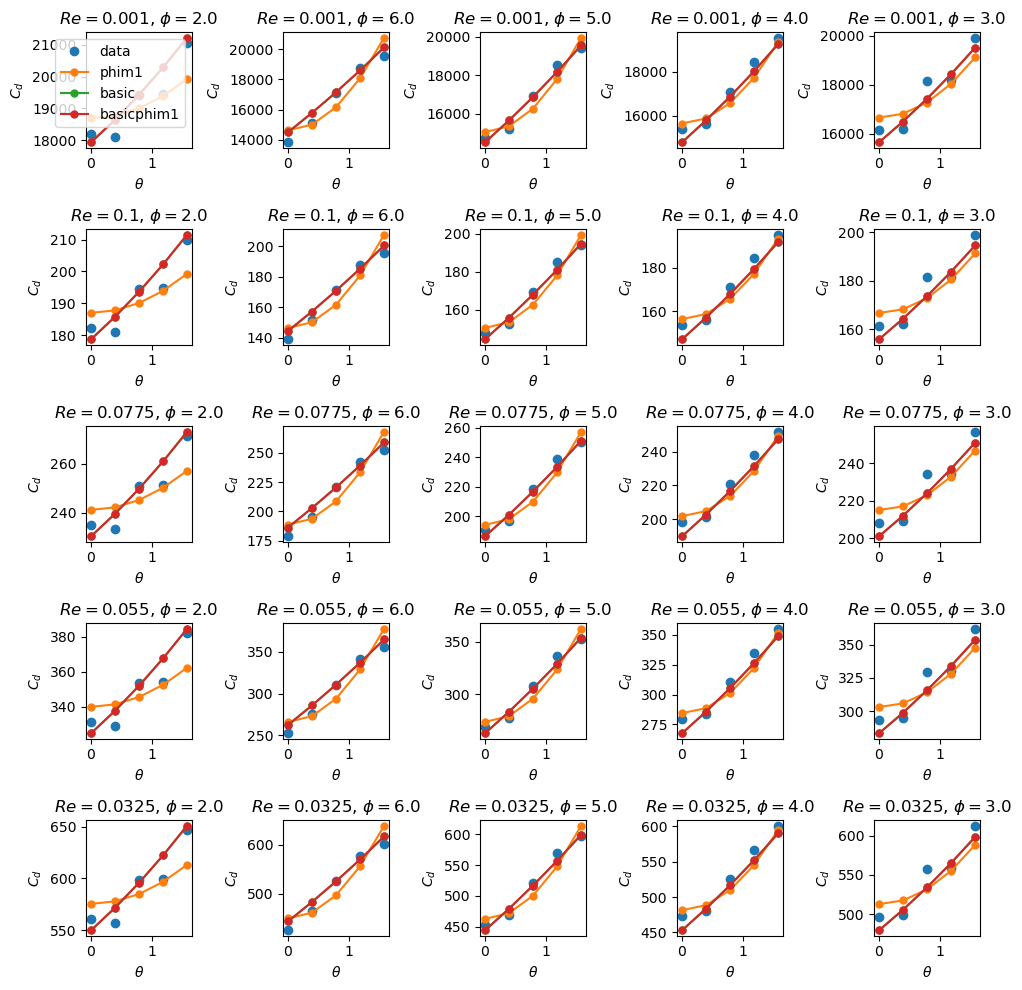

In [ ]:
# Grid of subplots for first 5 values of Re and phi

fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        Re0 = Re_list[-i] 
        phi0 = phi_list[-j] 

        datafilt = shuffled_df[(shuffled_df['Re'] == Re0) & (shuffled_df['phi'] == phi0)]
        theta_list = np.array(datafilt['theta'])
        Cd_list = np.array(datafilt['Exp C_d'])

        idxsort = np.argsort(theta_list)
        theta_sorted = theta_list[idxsort]
        Cd_sorted = Cd_list[idxsort]

        ax[i, j].plot(theta_sorted, Cd_sorted, 'o', label='data')

        for mode in mode_list:
            L = Libraries(mode, deg, deg_trigo)
            lib, lib_names = L.library(np.array(datafilt['Re']), np.array(datafilt['phi'], dtype=float), theta_sorted)
            Cd_pred = results[mode]['reg'].predict(lib)
            ax[i, j].plot(theta_sorted, Cd_pred, '.-', ms=10, label=mode)

        ax[i, j].set_xlabel(r'$\theta$')
        ax[i, j].set_ylabel(r'$C_d$')
        ax[i, j].set_title(r'$Re = $'+str(Re0)+r', $\phi = $'+str(phi0))
ax[0, 0].legend()

plt.tight_layout()